In [1]:
import sys
import os
sys.path.append(os.path.abspath("./MLP"))
sys.path.append(os.path.abspath("./datasets"))
sys.path.append(os.path.abspath("./KAN"))
from MLP import MLP
from MLPWrapper import MLPWrapper
from convert_data_to_input import CreateInput
from KAN import KANWrapper
from KAN_model import KANModel
import torch
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neural_network,pipeline,preprocessing,linear_model
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Prepare data

In [2]:
# get input data
deepmimo = True

function_folder = "seq_sin_pink_-3.32"

data = CreateInput(function_folder, deepmimo)

tensors = data.get_tensors()

           0         1         2         3         4         5         6  \
0  -1.071127 -1.450996 -2.636308 -0.329549  1.806948  1.296416 -0.135281   
1  -0.170276 -0.301575 -0.597102 -1.104663 -1.364563 -0.074106  0.991372   
2   0.572085  0.566875 -1.531421 -1.273426  0.067433 -1.421599  0.149881   
3   0.192757 -1.025377  0.187920 -0.748283 -0.556933  2.589141  1.456760   
4   0.760082  0.611429  0.951301  0.966506 -2.485724 -1.879708 -0.030122   
..       ...       ...       ...       ...       ...       ...       ...   
65 -0.564578  0.900035  2.013946 -1.208904  0.709127 -0.188264  0.551594   
66 -0.116741 -0.586607 -1.699672 -1.413316 -0.153026 -0.177135  0.802231   
67  0.873958 -0.945411 -1.499962 -1.318186 -0.230880  1.294361 -0.392952   
68  1.294384  0.157060 -0.481691 -1.494932 -0.351063  0.130868  0.154464   
69 -1.020470 -0.851054 -1.218941 -1.762148 -1.213100 -0.331554  1.601328   

           7         8         9  ...        20        21        22        23  \
0   2.

In [3]:
print(type(data))

<class 'convert_data_to_input.CreateInput'>


In [4]:
tensors['test'][1].shape

torch.Size([20, 30])

# Evaluate KAN

In [5]:
# find optimal params for KAN

kan_wrapper = KANWrapper(data=tensors,deepmimo=deepmimo)
input_size = tensors['test'][1].shape[1]

if deepmimo:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[input_size, 10, input_size], [input_size, 5, input_size], [input_size, 4, input_size], [input_size, 3, input_size], [input_size, 2, input_size]],
        'kan__grid': [3],
        'kan__k': [5],
        'kan__seed': [42],
        'kan__lr': [0.001],
        'kan__lamb': [0],
        'kan__deepmimo': [True],
        'kan__epochs': [20]
    }

else:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[1, 3, 1], [1, 3, 3, 1], [1, 3, 3, 3, 1], [1, 3, 1], [1, 5, 5, 1], [1, 5, 5, 5, 1], [1, 7, 1], [1, 7, 7, 1], [1, 7, 7, 7, 1]],
        'kan__grid': [3],
        'kan__k': [5],
        'kan__seed': [42],
        'kan__lr': [0.001, 0.0001],
        'kan__lamb': [0],
        'kan__deepmimo': [False],
        'kan__epochs': [20]
    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kan', kan_wrapper)
])

# Initialize RandomizedSearchCV
"""grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=5,                           # Number of parameter settings sampled
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=2
)"""
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=2
)
# Fit RandomizedSearchCV
grid_search.fit(kan_wrapper.X_train, kan_wrapper.y_train)

# Retrieve the best parameters and best score
grid_search.best_params_['kan__data'] = []          # remove annoying print
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

opt_params_KAN = grid_search.best_params_


Fitting 5 folds for each of 5 candidates, totalling 25 fits


| train_loss: 5.60e-04 | test_loss: 1.82e+00 | reg: 2.83e+01 | : 100%|█| 20/20 [00:08<00:00,  2.46it
| train_loss: 3.89e-04 | test_loss: 1.03e+00 | reg: 2.65e+01 | : 100%|█| 20/20 [00:08<00:00,  2.44it
| train_loss: 2.65e-04 | test_loss: 1.15e+00 | reg: 1.62e+01 | : 100%|█| 20/20 [00:07<00:00,  2.53it


[CV] END kan__data={'train': (tensor([[-1.0711, -1.4510, -2.6363,  ...,  0.4259, -0.9136, -1.7717],
        [-0.1703, -0.3016, -0.5971,  ...,  0.9312,  0.7050, -0.6900],
        [ 0.5721,  0.5669, -1.5314,  ...,  2.5869,  0.3795, -1.8531],
        ...,
        [ 0.8740, -0.9454, -1.5000,  ...,  1.0592, -1.5760, -1.2559],
        [ 1.2944,  0.1571, -0.4817,  ...,  1.5823,  0.6209,  1.0818],
        [-1.0205, -0.8511, -1.2189,  ...,  1.5855,  2.6655, -0.1116]]), tensor([[ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        ...,
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440]])), 'test': (tensor([[ 1.4875e+00,  4.4163e-01, -2.3036e+00, -3.1205e-01, -6.4209e-02,
         -9.1356

| train_loss: 4.90e-04 | test_loss: 1.58e+00 | reg: 1.80e+01 | : 100%|█| 20/20 [00:08<00:00,  2.47it
| train_loss: 1.84e-04 | test_loss: 1.04e+00 | reg: 1.72e+01 | : 100%|█| 20/20 [00:08<00:00,  2.36it
description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

[CV] END kan__data={'train': (tensor([[-1.0711, -1.4510, -2.6363,  ...,  0.4259, -0.9136, -1.7717],
        [-0.1703, -0.3016, -0.5971,  ...,  0.9312,  0.7050, -0.6900],
        [ 0.5721,  0.5669, -1.5314,  ...,  2.5869,  0.3795, -1.8531],
        ...,
        [ 0.8740, -0.9454, -1.5000,  ...,  1.0592, -1.5760, -1.2559],
        [ 1.2944,  0.1571, -0.4817,  ...,  1.5823,  0.6209,  1.0818],
        [-1.0205, -0.8511, -1.2189,  ...,  1.5855,  2.6655, -0.1116]]), tensor([[ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        ...,
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440]])), 'test': (tensor([[ 1.4875e+00,  4.4163e-01, -2.3036e+00, -3.1205e-01, -6.4209e-02,
         -9.1356

| train_loss: 4.40e-04 | test_loss: 1.15e+00 | reg: 2.82e+01 | : 100%|█| 20/20 [00:09<00:00,  2.20it
| train_loss: 4.29e-04 | test_loss: 1.37e+00 | reg: 2.67e+01 | : 100%|█| 20/20 [00:08<00:00,  2.25it
| train_loss: 3.40e-04 | test_loss: 2.37e+00 | reg: 2.53e+01 | : 100%|█| 20/20 [00:09<00:00,  2.10it


[CV] END kan__data={'train': (tensor([[-1.0711, -1.4510, -2.6363,  ...,  0.4259, -0.9136, -1.7717],
        [-0.1703, -0.3016, -0.5971,  ...,  0.9312,  0.7050, -0.6900],
        [ 0.5721,  0.5669, -1.5314,  ...,  2.5869,  0.3795, -1.8531],
        ...,
        [ 0.8740, -0.9454, -1.5000,  ...,  1.0592, -1.5760, -1.2559],
        [ 1.2944,  0.1571, -0.4817,  ...,  1.5823,  0.6209,  1.0818],
        [-1.0205, -0.8511, -1.2189,  ...,  1.5855,  2.6655, -0.1116]]), tensor([[ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        ...,
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440]])), 'test': (tensor([[ 1.4875e+00,  4.4163e-01, -2.3036e+00, -3.1205e-01, -6.4209e-02,
         -9.1356

| train_loss: 2.25e-04 | test_loss: 2.06e+00 | reg: 1.75e+01 | : 100%|█| 20/20 [00:08<00:00,  2.40it
description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

[CV] END kan__data={'train': (tensor([[-1.0711, -1.4510, -2.6363,  ...,  0.4259, -0.9136, -1.7717],
        [-0.1703, -0.3016, -0.5971,  ...,  0.9312,  0.7050, -0.6900],
        [ 0.5721,  0.5669, -1.5314,  ...,  2.5869,  0.3795, -1.8531],
        ...,
        [ 0.8740, -0.9454, -1.5000,  ...,  1.0592, -1.5760, -1.2559],
        [ 1.2944,  0.1571, -0.4817,  ...,  1.5823,  0.6209,  1.0818],
        [-1.0205, -0.8511, -1.2189,  ...,  1.5855,  2.6655, -0.1116]]), tensor([[ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        ...,
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440]])), 'test': (tensor([[ 1.4875e+00,  4.4163e-01, -2.3036e+00, -3.1205e-01, -6.4209e-02,
         -9.1356

| train_loss: 1.89e-04 | test_loss: 1.24e+00 | reg: 1.56e+01 | : 100%|█| 20/20 [00:08<00:00,  2.24it
| train_loss: 1.28e-04 | test_loss: 1.70e+00 | reg: 0.00e+00 | :  90%|▉| 18/20 [00:08<00:00,  2.01it

[CV] END kan__data={'train': (tensor([[-1.0711, -1.4510, -2.6363,  ...,  0.4259, -0.9136, -1.7717],
        [-0.1703, -0.3016, -0.5971,  ...,  0.9312,  0.7050, -0.6900],
        [ 0.5721,  0.5669, -1.5314,  ...,  2.5869,  0.3795, -1.8531],
        ...,
        [ 0.8740, -0.9454, -1.5000,  ...,  1.0592, -1.5760, -1.2559],
        [ 1.2944,  0.1571, -0.4817,  ...,  1.5823,  0.6209,  1.0818],
        [-1.0205, -0.8511, -1.2189,  ...,  1.5855,  2.6655, -0.1116]]), tensor([[ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        ...,
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440]])), 'test': (tensor([[ 1.4875e+00,  4.4163e-01, -2.3036e+00, -3.1205e-01, -6.4209e-02,
         -9.1356

| train_loss: 1.64e-04 | test_loss: 1.43e+00 | reg: 1.76e+01 | : 100%|█| 20/20 [00:08<00:00,  2.23it
| train_loss: 6.92e-02 | test_loss: 1.40e+00 | reg: 0.00e+00 | :  10%| | 2/20 [00:00<00:08,  2.11it/

[CV] END kan__data={'train': (tensor([[-1.0711, -1.4510, -2.6363,  ...,  0.4259, -0.9136, -1.7717],
        [-0.1703, -0.3016, -0.5971,  ...,  0.9312,  0.7050, -0.6900],
        [ 0.5721,  0.5669, -1.5314,  ...,  2.5869,  0.3795, -1.8531],
        ...,
        [ 0.8740, -0.9454, -1.5000,  ...,  1.0592, -1.5760, -1.2559],
        [ 1.2944,  0.1571, -0.4817,  ...,  1.5823,  0.6209,  1.0818],
        [-1.0205, -0.8511, -1.2189,  ...,  1.5855,  2.6655, -0.1116]]), tensor([[ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        ...,
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440]])), 'test': (tensor([[ 1.4875e+00,  4.4163e-01, -2.3036e+00, -3.1205e-01, -6.4209e-02,
         -9.1356

| train_loss: 1.77e-04 | test_loss: 1.09e+00 | reg: 1.65e+01 | : 100%|█| 20/20 [00:08<00:00,  2.36it
| train_loss: 3.66e-02 | test_loss: 1.34e+00 | reg: 0.00e+00 | :  15%|▏| 3/20 [00:01<00:08,  2.07it/

[CV] END kan__data={'train': (tensor([[-1.0711, -1.4510, -2.6363,  ...,  0.4259, -0.9136, -1.7717],
        [-0.1703, -0.3016, -0.5971,  ...,  0.9312,  0.7050, -0.6900],
        [ 0.5721,  0.5669, -1.5314,  ...,  2.5869,  0.3795, -1.8531],
        ...,
        [ 0.8740, -0.9454, -1.5000,  ...,  1.0592, -1.5760, -1.2559],
        [ 1.2944,  0.1571, -0.4817,  ...,  1.5823,  0.6209,  1.0818],
        [-1.0205, -0.8511, -1.2189,  ...,  1.5855,  2.6655, -0.1116]]), tensor([[ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        ...,
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440]])), 'test': (tensor([[ 1.4875e+00,  4.4163e-01, -2.3036e+00, -3.1205e-01, -6.4209e-02,
         -9.1356

| train_loss: 1.15e-04 | test_loss: 8.48e-01 | reg: 1.47e+01 | : 100%|█| 20/20 [00:09<00:00,  2.02it
| train_loss: 1.62e-04 | test_loss: 1.31e+00 | reg: 1.95e+01 | : 100%|█| 20/20 [00:09<00:00,  2.09it
description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

[CV] END kan__data={'train': (tensor([[-1.0711, -1.4510, -2.6363,  ...,  0.4259, -0.9136, -1.7717],
        [-0.1703, -0.3016, -0.5971,  ...,  0.9312,  0.7050, -0.6900],
        [ 0.5721,  0.5669, -1.5314,  ...,  2.5869,  0.3795, -1.8531],
        ...,
        [ 0.8740, -0.9454, -1.5000,  ...,  1.0592, -1.5760, -1.2559],
        [ 1.2944,  0.1571, -0.4817,  ...,  1.5823,  0.6209,  1.0818],
        [-1.0205, -0.8511, -1.2189,  ...,  1.5855,  2.6655, -0.1116]]), tensor([[ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        ...,
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440]])), 'test': (tensor([[ 1.4875e+00,  4.4163e-01, -2.3036e+00, -3.1205e-01, -6.4209e-02,
         -9.1356

| train_loss: 1.15e-04 | test_loss: 1.70e+00 | reg: 1.35e+01 | : 100%|█| 20/20 [00:09<00:00,  2.14it
| train_loss: 1.73e-04 | test_loss: 8.45e-01 | reg: 1.40e+01 | : 100%|█| 20/20 [00:09<00:00,  2.15it
description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

[CV] END kan__data={'train': (tensor([[-1.0711, -1.4510, -2.6363,  ...,  0.4259, -0.9136, -1.7717],
        [-0.1703, -0.3016, -0.5971,  ...,  0.9312,  0.7050, -0.6900],
        [ 0.5721,  0.5669, -1.5314,  ...,  2.5869,  0.3795, -1.8531],
        ...,
        [ 0.8740, -0.9454, -1.5000,  ...,  1.0592, -1.5760, -1.2559],
        [ 1.2944,  0.1571, -0.4817,  ...,  1.5823,  0.6209,  1.0818],
        [-1.0205, -0.8511, -1.2189,  ...,  1.5855,  2.6655, -0.1116]]), tensor([[ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        ...,
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440]])), 'test': (tensor([[ 1.4875e+00,  4.4163e-01, -2.3036e+00, -3.1205e-01, -6.4209e-02,
         -9.1356

| train_loss: 2.76e-04 | test_loss: 2.57e+00 | reg: 1.59e+01 | : 100%|█| 20/20 [00:08<00:00,  2.32it


[CV] END kan__data={'train': (tensor([[-1.0711, -1.4510, -2.6363,  ...,  0.4259, -0.9136, -1.7717],
        [-0.1703, -0.3016, -0.5971,  ...,  0.9312,  0.7050, -0.6900],
        [ 0.5721,  0.5669, -1.5314,  ...,  2.5869,  0.3795, -1.8531],
        ...,
        [ 0.8740, -0.9454, -1.5000,  ...,  1.0592, -1.5760, -1.2559],
        [ 1.2944,  0.1571, -0.4817,  ...,  1.5823,  0.6209,  1.0818],
        [-1.0205, -0.8511, -1.2189,  ...,  1.5855,  2.6655, -0.1116]]), tensor([[ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        ...,
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440]])), 'test': (tensor([[ 1.4875e+00,  4.4163e-01, -2.3036e+00, -3.1205e-01, -6.4209e-02,
         -9.1356

| train_loss: 1.40e-04 | test_loss: 6.32e-01 | reg: 1.42e+01 | : 100%|█| 20/20 [00:07<00:00,  2.64it
| train_loss: 4.97e-01 | test_loss: 2.56e+00 | reg: 0.00e+00 | :   5%| | 1/20 [00:00<00:07,  2.57it/

[CV] END kan__data={'train': (tensor([[-1.0711, -1.4510, -2.6363,  ...,  0.4259, -0.9136, -1.7717],
        [-0.1703, -0.3016, -0.5971,  ...,  0.9312,  0.7050, -0.6900],
        [ 0.5721,  0.5669, -1.5314,  ...,  2.5869,  0.3795, -1.8531],
        ...,
        [ 0.8740, -0.9454, -1.5000,  ...,  1.0592, -1.5760, -1.2559],
        [ 1.2944,  0.1571, -0.4817,  ...,  1.5823,  0.6209,  1.0818],
        [-1.0205, -0.8511, -1.2189,  ...,  1.5855,  2.6655, -0.1116]]), tensor([[ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        ...,
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440]])), 'test': (tensor([[ 1.4875e+00,  4.4163e-01, -2.3036e+00, -3.1205e-01, -6.4209e-02,
         -9.1356

| train_loss: 1.62e-04 | test_loss: 9.67e-01 | reg: 1.41e+01 | : 100%|█| 20/20 [00:08<00:00,  2.30it
| train_loss: 1.28e-04 | test_loss: 2.27e+00 | reg: 1.12e+01 | : 100%|█| 20/20 [00:08<00:00,  2.36it
| train_loss: 1.22e-04 | test_loss: 5.96e+00 | reg: 0.00e+00 | :  95%|▉| 19/20 [00:07<00:00,  2.66it

[CV] END kan__data={'train': (tensor([[-1.0711, -1.4510, -2.6363,  ...,  0.4259, -0.9136, -1.7717],
        [-0.1703, -0.3016, -0.5971,  ...,  0.9312,  0.7050, -0.6900],
        [ 0.5721,  0.5669, -1.5314,  ...,  2.5869,  0.3795, -1.8531],
        ...,
        [ 0.8740, -0.9454, -1.5000,  ...,  1.0592, -1.5760, -1.2559],
        [ 1.2944,  0.1571, -0.4817,  ...,  1.5823,  0.6209,  1.0818],
        [-1.0205, -0.8511, -1.2189,  ...,  1.5855,  2.6655, -0.1116]]), tensor([[ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        ...,
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440]])), 'test': (tensor([[ 1.4875e+00,  4.4163e-01, -2.3036e+00, -3.1205e-01, -6.4209e-02,
         -9.1356

| train_loss: 1.17e-04 | test_loss: 5.96e+00 | reg: 9.90e+00 | : 100%|█| 20/20 [00:08<00:00,  2.44it
| train_loss: 1.18e-04 | test_loss: 3.36e+00 | reg: 1.00e+01 | : 100%|█| 20/20 [00:08<00:00,  2.38it
| train_loss: 1.37e-04 | test_loss: 8.04e+00 | reg: 0.00e+00 | :  95%|▉| 19/20 [00:07<00:00,  2.48it

[CV] END kan__data={'train': (tensor([[-1.0711, -1.4510, -2.6363,  ...,  0.4259, -0.9136, -1.7717],
        [-0.1703, -0.3016, -0.5971,  ...,  0.9312,  0.7050, -0.6900],
        [ 0.5721,  0.5669, -1.5314,  ...,  2.5869,  0.3795, -1.8531],
        ...,
        [ 0.8740, -0.9454, -1.5000,  ...,  1.0592, -1.5760, -1.2559],
        [ 1.2944,  0.1571, -0.4817,  ...,  1.5823,  0.6209,  1.0818],
        [-1.0205, -0.8511, -1.2189,  ...,  1.5855,  2.6655, -0.1116]]), tensor([[ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        ...,
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440]])), 'test': (tensor([[ 1.4875e+00,  4.4163e-01, -2.3036e+00, -3.1205e-01, -6.4209e-02,
         -9.1356

| train_loss: 1.34e-04 | test_loss: 4.36e+00 | reg: 9.79e+00 | : 100%|█| 20/20 [00:08<00:00,  2.45it
| train_loss: 1.31e-04 | test_loss: 8.04e+00 | reg: 9.90e+00 | : 100%|█| 20/20 [00:08<00:00,  2.47it


[CV] END kan__data={'train': (tensor([[-1.0711, -1.4510, -2.6363,  ...,  0.4259, -0.9136, -1.7717],
        [-0.1703, -0.3016, -0.5971,  ...,  0.9312,  0.7050, -0.6900],
        [ 0.5721,  0.5669, -1.5314,  ...,  2.5869,  0.3795, -1.8531],
        ...,
        [ 0.8740, -0.9454, -1.5000,  ...,  1.0592, -1.5760, -1.2559],
        [ 1.2944,  0.1571, -0.4817,  ...,  1.5823,  0.6209,  1.0818],
        [-1.0205, -0.8511, -1.2189,  ...,  1.5855,  2.6655, -0.1116]]), tensor([[ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        ...,
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440]])), 'test': (tensor([[ 1.4875e+00,  4.4163e-01, -2.3036e+00, -3.1205e-01, -6.4209e-02,
         -9.1356

| train_loss: 1.61e-04 | test_loss: 2.74e+00 | reg: 1.03e+01 | : 100%|█| 20/20 [00:03<00:00,  5.22it


[CV] END kan__data={'train': (tensor([[-1.0711, -1.4510, -2.6363,  ...,  0.4259, -0.9136, -1.7717],
        [-0.1703, -0.3016, -0.5971,  ...,  0.9312,  0.7050, -0.6900],
        [ 0.5721,  0.5669, -1.5314,  ...,  2.5869,  0.3795, -1.8531],
        ...,
        [ 0.8740, -0.9454, -1.5000,  ...,  1.0592, -1.5760, -1.2559],
        [ 1.2944,  0.1571, -0.4817,  ...,  1.5823,  0.6209,  1.0818],
        [-1.0205, -0.8511, -1.2189,  ...,  1.5855,  2.6655, -0.1116]]), tensor([[ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        ...,
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440]])), 'test': (tensor([[ 1.4875e+00,  4.4163e-01, -2.3036e+00, -3.1205e-01, -6.4209e-02,
         -9.1356

| train_loss: 1.76e-04 | test_loss: 7.77e-01 | reg: 1.32e+01 | : 100%|█| 20/20 [00:04<00:00,  4.92it

Best Parameters: {'kan__data': [], 'kan__deepmimo': True, 'kan__epochs': 20, 'kan__grid': 3, 'kan__k': 5, 'kan__lamb': 0, 'kan__lr': 0.001, 'kan__seed': 42, 'kan__width': [[30, 0], [4, 0], [30, 0]]}
Best Cross-Validation Score: -0.335230278968811


In [6]:
# evaluate KAN with optimal params
kan_model = KANModel(width=opt_params_KAN['kan__width'], grid=opt_params_KAN['kan__grid'], k=opt_params_KAN['kan__k'], seed=opt_params_KAN['kan__seed'], lr=opt_params_KAN['kan__lr'], lamb=opt_params_KAN['kan__lamb'], deepmimo=deepmimo, epochs=100)
kan_model.load_data(tensors)
loss_data, time_elapsed = kan_model.fit()
y_preds = kan_model.predict()

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.08e-04 | test_loss: 1.37e+00 | reg: 1.78e+01 | : 100%|█| 100/100 [00:11<00:00,  8.93


saving model version 0.1


In [7]:
"""print(y_preds['preds'][0].shape)
x=np.linspace(-10, 10, 20)
many_x = np.linspace(-10, 10, 200)
plt.plot(x, y_preds['preds'][0], "o")
plt.plot(many_x, np.sin(many_x))
plt.plot(x, tensors['train'][0][0], ".")
plt.show()"""

'print(y_preds[\'preds\'][0].shape)\nx=np.linspace(-10, 10, 20)\nmany_x = np.linspace(-10, 10, 200)\nplt.plot(x, y_preds[\'preds\'][0], "o")\nplt.plot(many_x, np.sin(many_x))\nplt.plot(x, tensors[\'train\'][0][0], ".")\nplt.show()'

In [8]:
"""if deepmimo:
    kan_model = KANModel(width=[20, 10,10, 20], grid=20, k=3, seed=42, lr=0.1, lamb=0,deepmimo=deepmimo,steps=10)
    kan_model.load_data(tensors)
    loss_data, time_elapsed = kan_model.fit()
    y_preds = kan_model.predict()"""

'if deepmimo:\n    kan_model = KANModel(width=[20, 10,10, 20], grid=20, k=3, seed=42, lr=0.1, lamb=0,deepmimo=deepmimo,steps=10)\n    kan_model.load_data(tensors)\n    loss_data, time_elapsed = kan_model.fit()\n    y_preds = kan_model.predict()'

torch.Size([30])
30


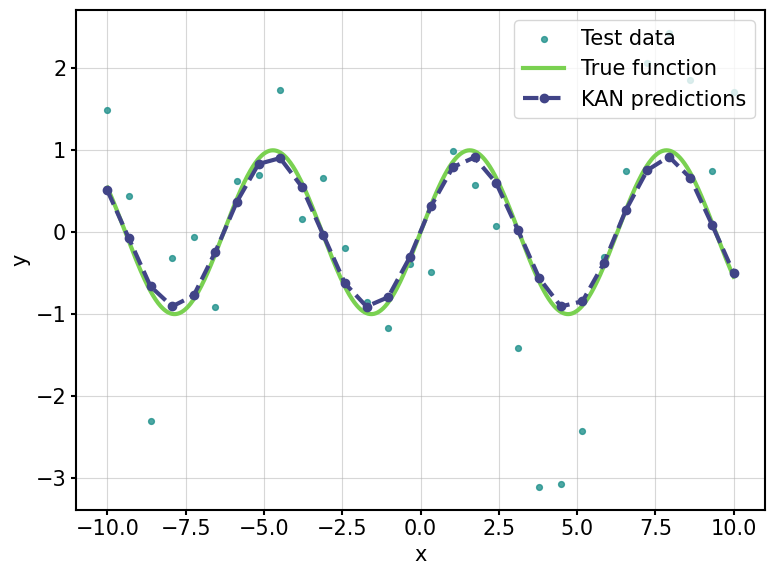

In [9]:
# plot pred and true
if deepmimo:
    #kan_model.plot_deepmimo(data=tensors, y_preds=y_preds['preds'], type_='test', save=False)
    kan_model.plot_sequence(data=tensors, y_preds=y_preds['preds'], type_='test', save=False)
else:
    kan_model.plot_prediction(data=tensors, y_preds=y_preds['preds'], type_='test', save=False)

In [ ]:
# plot noise and true
# if deepmimo:
#     kan_model.plot_deepmimo(data=tensors, y_preds=tensors['test'][0][:2,:], type_='test', save=False)

TypeError: plot_deepmimo() got an unexpected keyword argument 'data'

In [ ]:
# diffrence in noise and true
#torch.sum(np.abs(tensors['test'][0][:1,:] - tensors['test'][1][:1,:]))

In [ ]:
# diffrence pred and true
#torch.sum(np.abs(y_preds['preds'][0] - tensors['test'][1][:1,:]))

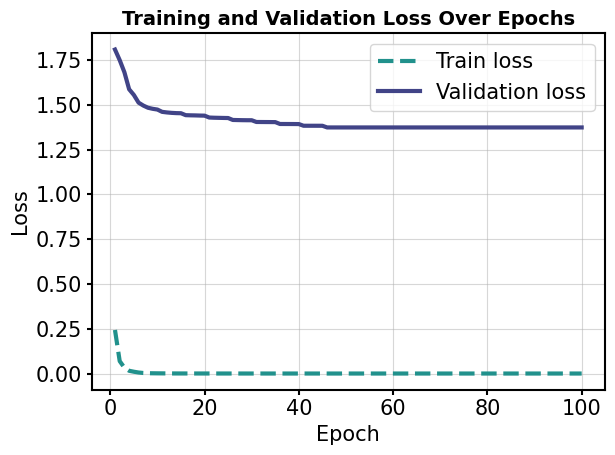

In [11]:
# plot loss
kan_model.plot_loss(loss_data=loss_data, save=False)

# Evaluate MLP

In [ ]:
# find optimal params for mlp
mlp_wrapper = MLPWrapper(data=tensors,deepmimo=deepmimo)

if deepmimo:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [1024],
        'mlp__hidden_size': [[64,64],[500,500],[2000],[1000,1000],[300,300,300],[5000],[3000,3000],[32,32],[128,128],[256,64]],
        'mlp__output_size': [1024],
        'mlp__epochs': [100],
        'mlp__deepmimo': [True]
    }

else:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [1],
        'mlp__hidden_size': [[3], [3, 3], [3, 3, 3], [5], [5, 5], [5, 5, 5], [7], [7, 7], [7, 7, 7]],
        'mlp__output_size': [1],
        'mlp__epochs': [20, 21],
        'mlp__deepmimo': [False],
        'mlp__lr': [0.001]
    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Example preprocessor
    ('mlp', mlp_wrapper)
])

# Initialize RandomizedSearchCV
grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=5,  # Number of parameter settings sampled
    cv=5,        # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=0
)

# Fit RandomizedSearchCV
grid_search.fit(mlp_wrapper.X_train, mlp_wrapper.y_train)

# Retrieve the best parameters and best score
grid_search.best_params_['mlp__data'] = []          # remove annoying print
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

opt_params_MLP = grid_search.best_params_

In [ ]:
# evaluate KAN with optimal params
mlp_model = MLP(input_size=opt_params_MLP['mlp__input_size'], hidden_sizes=opt_params_MLP['mlp__hidden_size'], output_size=opt_params_MLP['mlp__output_size'])
mlp_model.load_data(tensors, deepmimo=deepmimo)
loss_data_MLP, time_elapsed_MLP = mlp_model.fit(mlp_model.X_train, mlp_model.y_train, n_epochs=100, cross_validation=False, deepmimo=deepmimo)
y_preds_MLP = mlp_model.predict(mlp_model.X_test,eval=True)

In [ ]:
# plot predictions
if deepmimo:
    mlp_model.plot_deepmimo(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=False)
else:
    mlp_model.plot_prediction(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=False)

In [ ]:
# plot loss

mlp_model.plot_loss(loss_data=loss_data_MLP, save=False, deepmimo=deepmimo)